# Test: velocity gradients with velocity_tools

In [1]:
import numpy as np
import os
import scipy.linalg # for initial guesses
from scipy.optimize import curve_fit # to obtain the fit with errors
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from matplotlib import cm
from astropy.coordinates import SkyCoord
import pandas as pd
import sys
sys.path.append('/home/mvaldivi/velocity_tools/')
from velocity_tools import vgrad
%matplotlib widget

In [2]:
paramsfile = '../clustering/clusters_red_N2Hp.fits'
molecule = 'N2Hp' # we modify to use several molecules
clump = 'red'


In [4]:
params, parheader = fits.getdata(paramsfile, header=True)
velfield = params[1] # km/s
velerror = params[4]

alpha0, delta_alpha, ialpha0, lenalpha = parheader['CRVAL1'], parheader['CDELT1'], parheader['CRPIX1'], parheader['NAXIS1']
delta0, delta_delta, idelta0, lendelta = parheader['CRVAL2'], parheader['CDELT2'], parheader['CRPIX2'], parheader['NAXIS2']

beammaj, beammin, bpa = (parheader['BMAJ'], parheader['BMIN'], parheader['BPA']) * u.deg

equivradius = np.sqrt(beammaj * beammin / (4 * np.log(2)))  #equivalence with solid angle of beam in radius form
nbeams = 2
samplingwidth = equivradius * nbeams * 2 # 2 beams
minarea_calc = (np.pi * (samplingwidth.value/delta_delta/2) ** 2) / 3 

In [17]:
print("Running program for a gradient with a width of {} beams".format(nbeams))
print("Beam size: {0} x {1}".format(np.round(beammaj.to(u.arcsec), 1), np.round(beammin.to(u.arcsec), 1)))
print("The equivalent radius is {0} pixels, the sample radius is {1}, needs a minimum of {2} pixels".format(np.round(equivradius.value/delta_delta, 1), 
                                                                                                            np.round(samplingwidth/delta_delta, 1),
                                                                                                            np.round(minarea_calc, 1)))


Running program for a gradient with a width of 2 beams
Beam size: 5.8 arcsec x 5.5 arcsec
The equivalent radius is 3.7 pixels, the sample radius is 14.8 deg, needs a minimum of 57.4 pixels


In [ ]:
# newhead = parheader.copy()
# newhead['bunit'] = 'km s-1'
# newhead['naxis'] = 2
# del newhead['crval3']
# del newhead['crpix3']
# del newhead['cdelt3']
# del newhead['ctype3']
# del newhead['naxis3']

In [ ]:
# fits.writeto(paramsfile[:-5]+'_vel_unc.fits', velerror, newhead)

In [ ]:
# x_t = np.array([alpha0 + delta_alpha/np.cos(alpha0*np.pi/180)*(i-ialpha0) for i in range(lenalpha)]) * u.deg
# y_t = np.array([delta0 + delta_delta*(i-idelta0) for i in range(lendelta)]) * u.deg
# xv, yv = np.meshgrid(x_t, y_t, indexing='xy')
# we already know the definition of the radius is technically wrong, this is just for comparison, will fix later


In [21]:
result_all = vgrad.vfit_image(paramsfile[:-5]+'_vel.fits', paramsfile[:-5]+'_vel_unc.fits',
                              distance=298*u.pc, width = samplingwidth.to(u.arcsec))



{'grad': 1.3562978472168996, 'grad_err': 0.0004922448058219536, 'posang': -31.808776850874253, 'paerr': 0.05917364126608099, 'chisq': 175.12685273718066, 'vc': 8.02616322020721, 'vc_err': 0.0, 'v_pred': array([7.46065833, 7.46159965, 7.46254096, ..., 8.31763935, 8.31858067,
       8.31952199])}


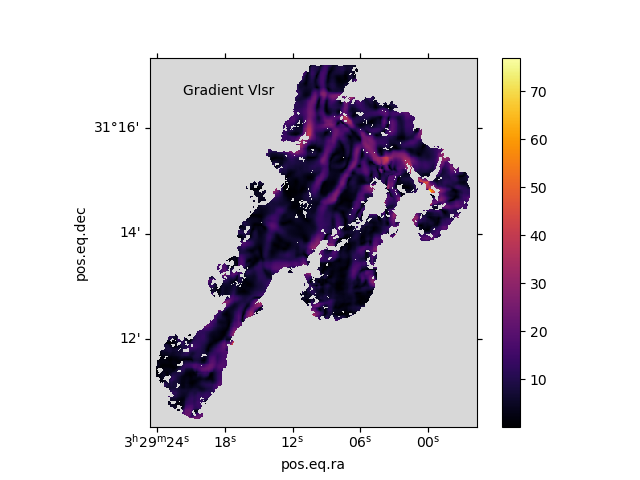

In [23]:
wcs = WCS(parheader).celestial
cmap = cm.get_cmap(name='inferno').copy()
cmap.set_bad(color='0.85')
fig2 = plt.figure()
ax2 = plt.subplot(projection=wcs)
im2 = ax2.imshow(result_all['grad'], cmap=cmap, interpolation='none')

ax2.text(0.1, 0.9, 'Gradient Vlsr', transform=ax2.transAxes)
fig2.colorbar(im2, ax=ax2)

Comparison with what I did before

In [29]:
ns = 7
x_map = np.arange(0, parheader['NAXIS1'])
y_map = np.arange(0, parheader['NAXIS2'])
xv_map, yv_map = np.meshgrid(x_map, y_map)
ra_map, dec_map = wcs.wcs_pix2world(xv_map, yv_map, 0)
#
gd_grad = np.isfinite(result_all['grad']) & (xv_map % ns == 0) & (yv_map % ns == 0)
ra_grad = ra_map[gd_grad]
dec_grad = dec_map[gd_grad]
grad_abs = result_all['grad'][gd_grad]
grad_pa = result_all['posang'][gd_grad]
#
grad_x = grad_abs * np.cos(np.deg2rad(grad_pa + 90))
grad_y = grad_abs * np.sin(np.deg2rad(grad_pa + 90))

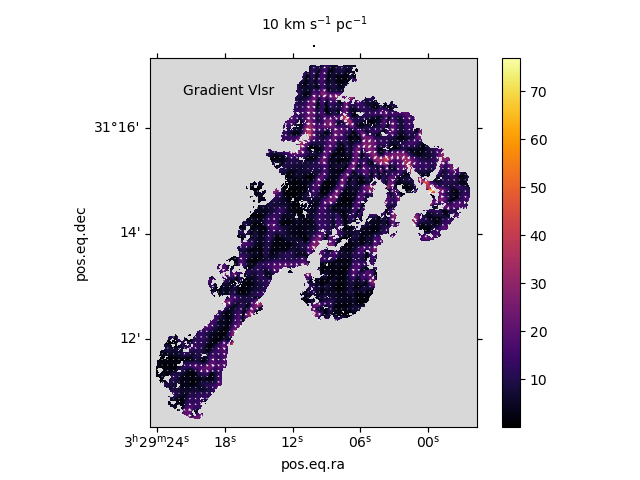

In [34]:
fig2 = plt.figure()
ax2 = plt.subplot(projection=wcs)
im2 = ax2.imshow(result_all['grad'], cmap=cmap, interpolation='none')
quiv = ax2.quiver(xv_map[gd_grad], yv_map[gd_grad], grad_x, grad_y, scale=5, 
    pivot='mid', width=0.003, scale_units='xy', angles='xy', 
    headlength=3.5, headaxislength=3.0, color='w')
ax2.quiverkey(quiv, X=0.5*parheader['NAXIS1'], Y=1.03*parheader['NAXIS2'], 
    U=10, label=r'10 km s$^{-1}$ pc$^{-1}$', coordinates='data', color='k')
ax2.text(0.1, 0.9, 'Gradient Vlsr', transform=ax2.transAxes)
fig2.colorbar(im2, ax=ax2)

In [35]:
gradabs_old, e_gradabs_old = fits.getdata('gradients/vel_grad_magnitude_N2Hp_red.fits')

In [37]:
gradabs_new_flat = result_all['grad'].flatten()
gradabs_old_flat = gradabs_old.flatten()

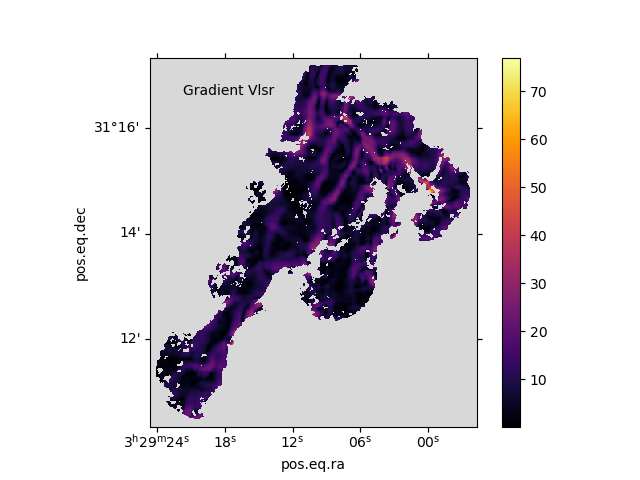

In [39]:
fig2 = plt.figure()
ax2 = plt.subplot(projection=wcs)
im2 = ax2.imshow(gradabs_old, cmap=cmap, interpolation='none')

ax2.text(0.1, 0.9, 'Gradient Vlsr', transform=ax2.transAxes)
fig2.colorbar(im2, ax=ax2)

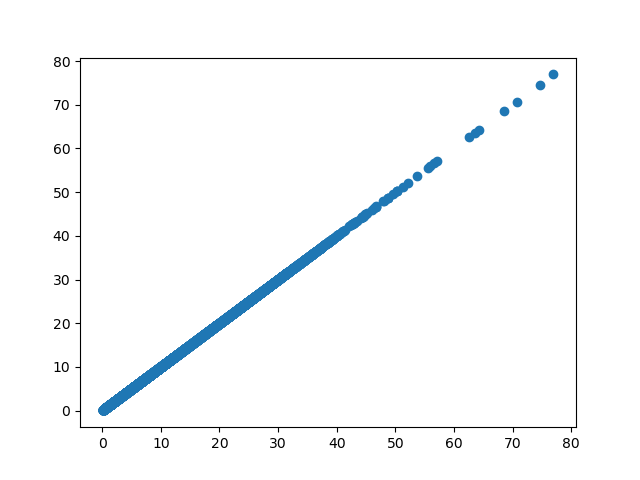

In [38]:
fig= plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gradabs_old_flat, gradabs_new_flat)